# Final Cleanup

In [388]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import random

In [389]:
# Adjust settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
%matplotlib inline

In [390]:
# Load preprocessed dataset
data_path = '../data/interim/'
df = pd.read_pickle(os.path.join(data_path, 'features.pkl'))

In [391]:
# Having a look at the dataset
print(df.shape)
print(df.dtypes)
df.head()

(11892, 28)
flt_offblock        datetime64[ns]
flt_onblock         datetime64[ns]
flt_ac_reg                  object
dep_delay                  float64
flt_sched_dep       datetime64[ns]
flt_sched_arr       datetime64[ns]
gnd_mingt                  float64
arr_delay                  float64
AC_type                   category
routing                     object
sched_gt                   float64
act_gt                     float64
sched_gt_before            float64
act_gt_before              float64
cp_count                     int64
ca_count                     int64
act_trans_time               int64
sched_trans_time             int64
cc_cp_ca                    object
cc_count                     int64
day_of_week                 object
hour_of_day_dep             object
hour_of_day_arr             object
flight_of_day               object
cc_types                    object
cc_roles                    object
mod_sched_arr                int64
density                    float64
dtype: o

,flt_offblock,flt_onblock,flt_ac_reg,dep_delay,flt_sched_dep,flt_sched_arr,gnd_mingt,arr_delay,AC_type,routing,sched_gt,act_gt,sched_gt_before,act_gt_before,cp_count,ca_count,act_trans_time,sched_trans_time,cc_cp_ca,cc_count,day_of_week,hour_of_day_dep,hour_of_day_arr,flight_of_day,cc_types,cc_roles,mod_sched_arr,density
495776,2019-06-16 20:33:00,2019-06-16 23:06:00,ECLBRX,13.0,2019-06-16 20:20:00,2019-06-16 23:00:00,40.0,6.0,320,Vaughnberg_East Carmen,NaN,NaN,50.0,72.0,2,4,40,50,none,0,6,20,23,5,1,[],1380,0.01857
1001376,2019-06-12 20:18:00,2019-06-12 22:54:00,ECLDGX,3.0,2019-06-12 20:15:00,2019-06-12 23:00:00,40.0,-6.0,319,Kaylashire_East Carmen,NaN,NaN,60.0,-8.0,2,3,37,60,none,0,2,20,23,6,1,[],1380,0.01857
646176,2019-06-30 20:34:00,2019-06-30 23:00:00,ECLBVX,14.0,2019-06-30 20:20:00,2019-06-30 23:00:00,40.0,0.0,320,Vaughnberg_East Carmen,NaN,NaN,50.0,-9.0,2,4,19,50,none,0,6,20,23,5,1,[],1380,0.01857
245776,2019-06-02 20:33:00,2019-06-02 22:52:00,ECLBKX,13.0,2019-06-02 20:20:00,2019-06-02 23:00:00,40.0,-8.0,320,Vaughnberg_East Carmen,NaN,NaN,50.0,64.0,2,4,21,50,none,0,6,20,23,5,1,[],1380,0.01857
204976,2019-06-23 20:32:00,2019-06-23 22:51:00,ECLBIX,12.0,2019-06-23 20:20:00,2019-06-23 23:00:00,40.0,-9.0,320,Vaughnberg_East Carmen,NaN,NaN,50.0,66.0,2,4,33,50,none,0,6,20,23,5,1,[],1380,0.01857


In [392]:
# Drop columns not needed for modeling
df.drop(columns=['flt_offblock', # datetime cannot be handled by some algorithms
                'flt_onblock', # datetime cannot be handled by some algorithms
                'flt_sched_dep', # datetime cannot be handled by some algorithms
                'flt_sched_arr', # datetime cannot be handled by some algorithms
                'sched_gt', # sched_gt before will be used
                'act_gt', # Not available at the start of the day as it is an actual value
                'act_gt_before', # Not available at the start of the day as it is an actual value
                'act_trans_time', # Not available at the start of the day as it is an actual value
                'cc_roles'], # Some algorithms cannot handle nested lists and most information is encoded in seperate variables
                inplace=True)

## Outlier identification

In [393]:
# Function to identify outliers for all continous variables
def find_outliers(df, col):
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    iqr = q75 - q25
    ll = q25 - 1.5 * iqr
    ul = q75 + 1.5 * iqr

    ls = df.index[(df[col] < ll) | (df[col] > ul)]

    return ls

outlier_idx = []

columns = df[['arr_delay', 'sched_gt_before', 'dep_delay']]

for col in columns:
    if df[col].dtype in ['int64', 'float64']:
        outlier_idx.extend(find_outliers(df, col))

In [394]:
# Function to remove outliers from dataframe
def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df
    
df_cleaned = remove(df, outlier_idx)

In [395]:
print(df.shape)
print(df_cleaned.shape)

(11892, 19)
(10218, 19)


In [396]:
print(df_cleaned.shape)
df_cleaned = df_cleaned[df_cleaned['sched_gt_before']>0]
print(df_cleaned.shape)

(10218, 19)
(8242, 19)


In [397]:
df.head()

,flt_ac_reg,dep_delay,gnd_mingt,arr_delay,AC_type,routing,sched_gt_before,cp_count,ca_count,sched_trans_time,cc_cp_ca,cc_count,day_of_week,hour_of_day_dep,hour_of_day_arr,flight_of_day,cc_types,mod_sched_arr,density
495776,ECLBRX,13.0,40.0,6.0,320,Vaughnberg_East Carmen,50.0,2,4,50,none,0,6,20,23,5,1,1380,0.01857
1001376,ECLDGX,3.0,40.0,-6.0,319,Kaylashire_East Carmen,60.0,2,3,60,none,0,2,20,23,6,1,1380,0.01857
646176,ECLBVX,14.0,40.0,0.0,320,Vaughnberg_East Carmen,50.0,2,4,50,none,0,6,20,23,5,1,1380,0.01857
245776,ECLBKX,13.0,40.0,-8.0,320,Vaughnberg_East Carmen,50.0,2,4,50,none,0,6,20,23,5,1,1380,0.01857
204976,ECLBIX,12.0,40.0,-9.0,320,Vaughnberg_East Carmen,50.0,2,4,50,none,0,6,20,23,5,1,1380,0.01857


## Data visualization for all continous variables

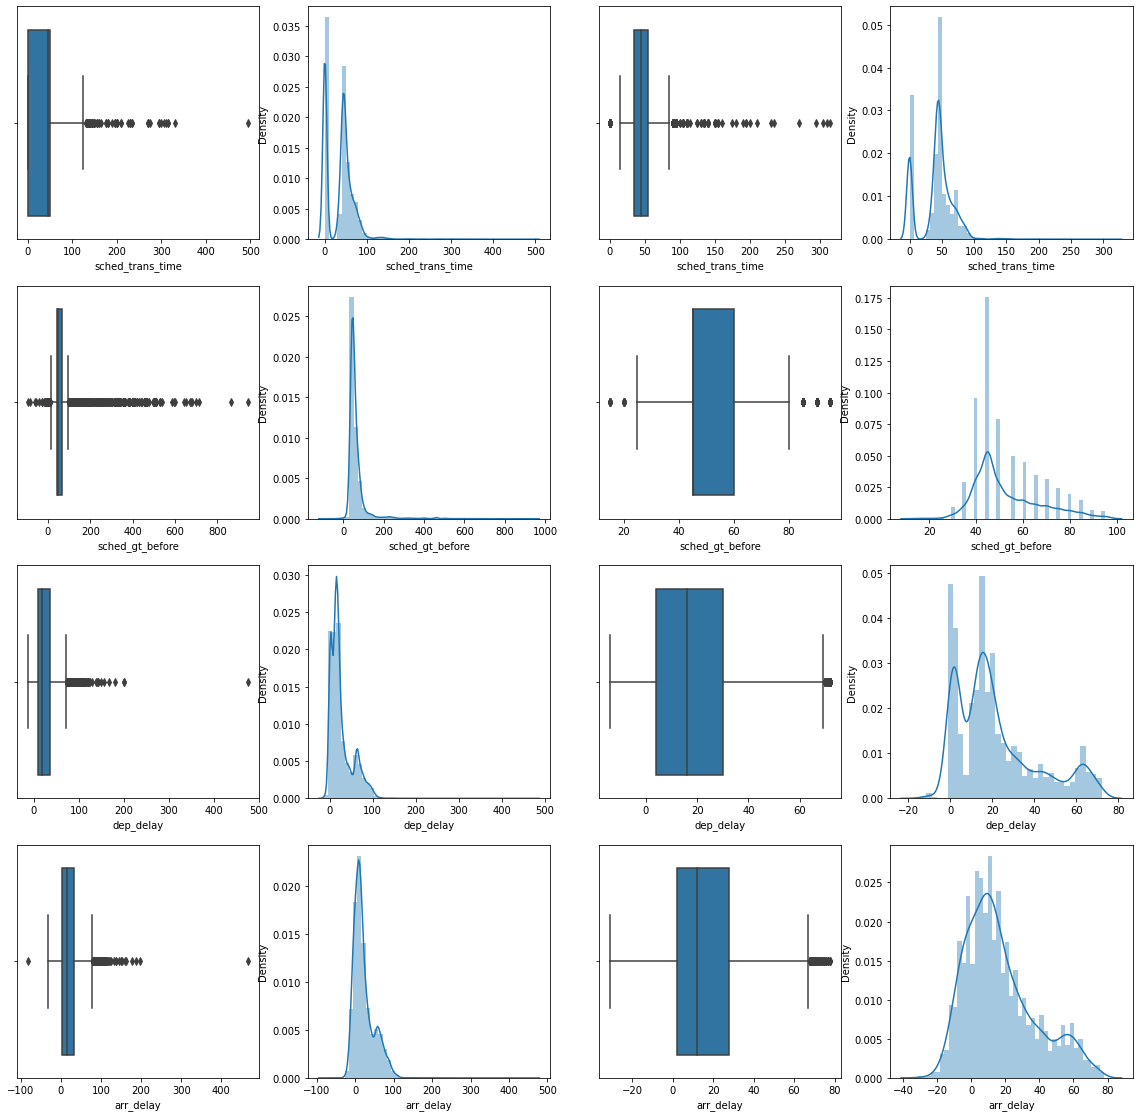

In [398]:
# Printing box- and distplots for cleaned and uncleaned data.

plt.figure(figsize=(20,30))

plt.subplot(6,4,1)
sns.boxplot(x=df['sched_trans_time'])
plt.subplot(6,4,2)
sns.distplot(df['sched_trans_time'])
plt.subplot(6,4,3)
sns.boxplot(x=df_cleaned['sched_trans_time'])
plt.subplot(6,4,4)
sns.distplot(df_cleaned['sched_trans_time'])

plt.subplot(6,4,5)
sns.boxplot(x=df['sched_gt_before'])
plt.subplot(6,4,6)
sns.distplot(df['sched_gt_before'])
plt.subplot(6,4,7)
sns.boxplot(x=df_cleaned['sched_gt_before'])
plt.subplot(6,4,8)
sns.distplot(df_cleaned['sched_gt_before'])

plt.subplot(6,4,9)
sns.boxplot(x=df['dep_delay'])
plt.subplot(6,4,10)
sns.distplot(df['dep_delay'])
plt.subplot(6,4,11)
sns.boxplot(x=df_cleaned['dep_delay'])
plt.subplot(6,4,12)
sns.distplot(df_cleaned['dep_delay'])

plt.subplot(6,4,13)
sns.boxplot(x=df['arr_delay'])
plt.subplot(6,4,14)
sns.distplot(df['arr_delay'])
plt.subplot(6,4,15)
sns.boxplot(x=df_cleaned['arr_delay'])
plt.subplot(6,4,16)
sns.distplot(df_cleaned['arr_delay'])

plt.show()

<AxesSubplot:xlabel='arr_delay', ylabel='Density'>

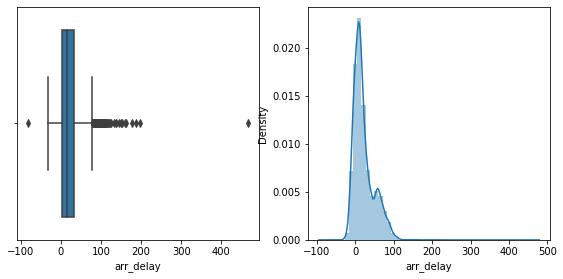

In [399]:
plt.figure(figsize=(20,30))

plt.subplot(6,4,13)
sns.boxplot(x=df['arr_delay'])
plt.subplot(6,4,14)
sns.distplot(df['arr_delay'])

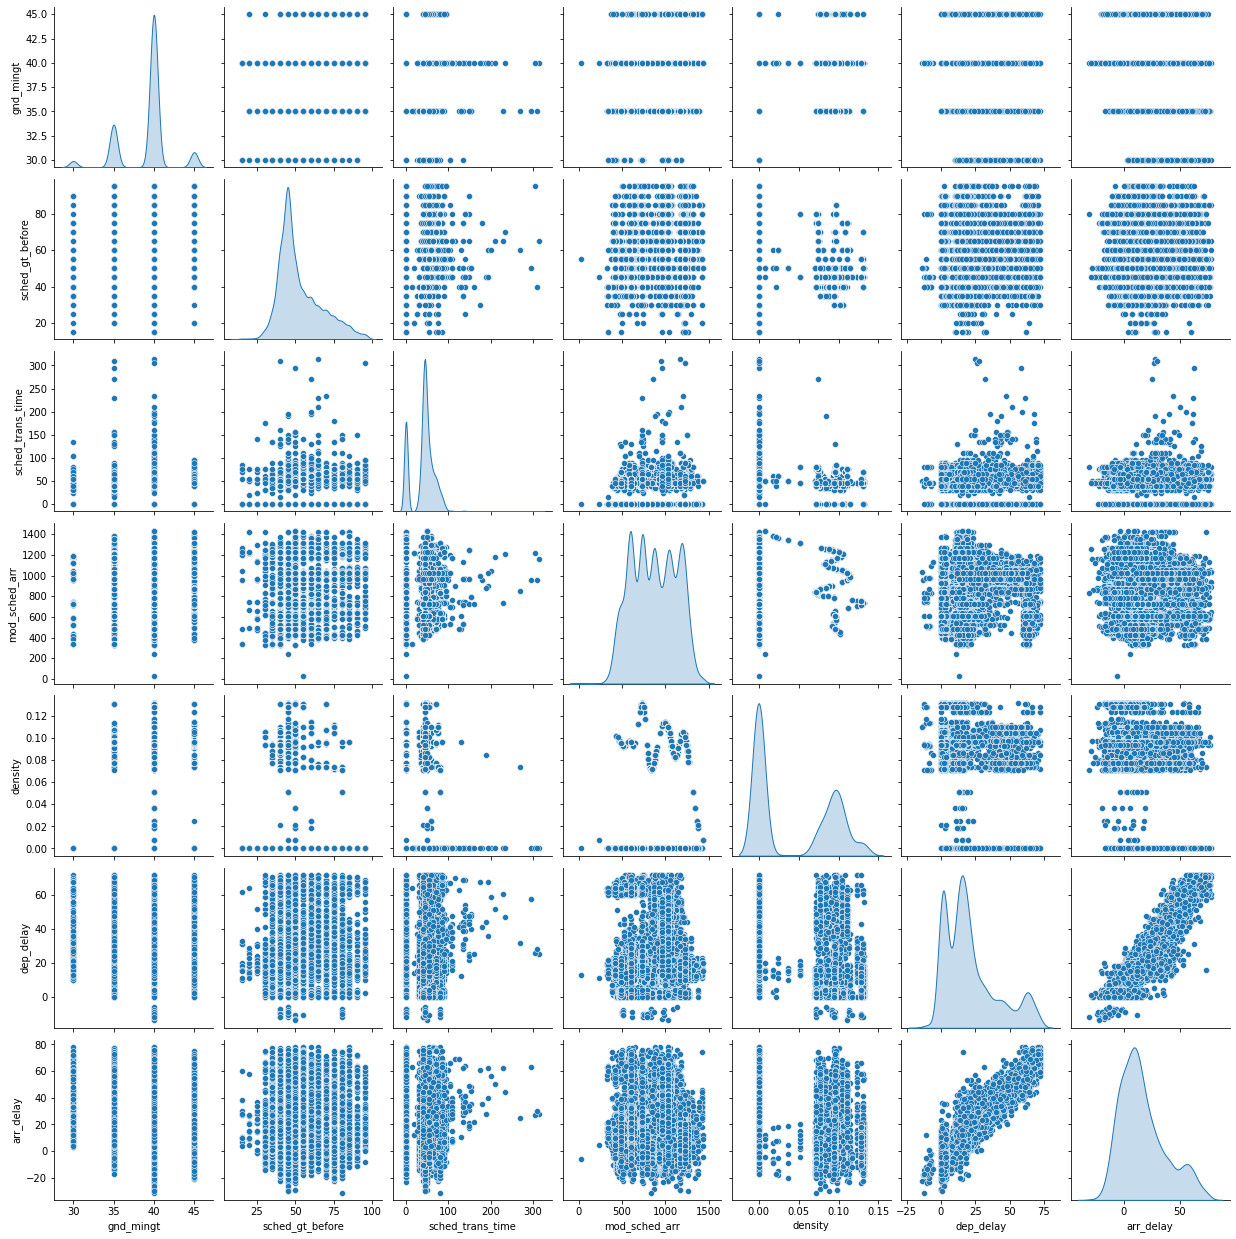

In [400]:
# Pairplot of all numerical values including dependent variable
data = df_cleaned[['gnd_mingt', 'sched_gt_before', 'sched_trans_time', 'mod_sched_arr', 'density', 'dep_delay', 'arr_delay']]
sns.pairplot(df_cleaned, vars=data, diag_kind='kde')

<AxesSubplot:>

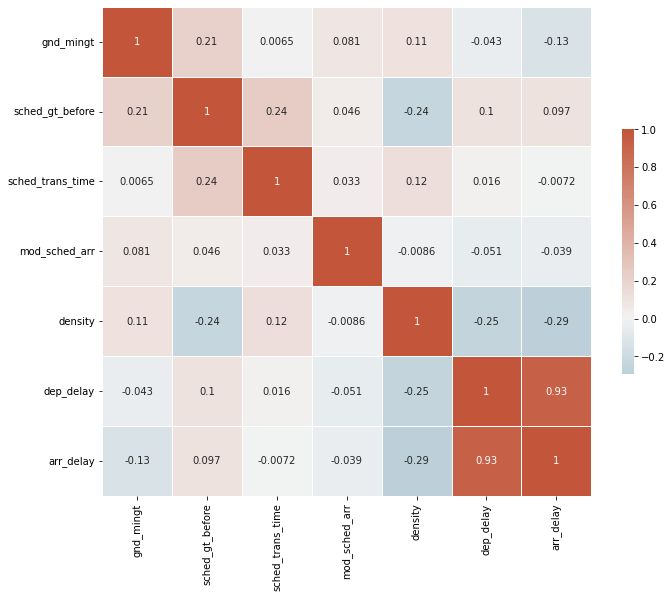

In [401]:
corr = data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

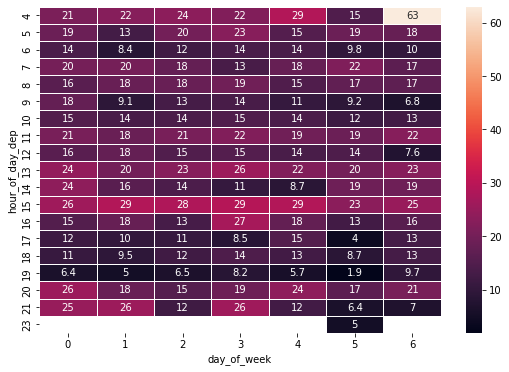

In [402]:
# Heatmap for day of week, hour of day and arr_delay
data = df_cleaned.pivot_table(index='hour_of_day_dep', columns='day_of_week', values='arr_delay', aggfunc=np.mean)
f, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(data, annot=True,linewidths=.5, ax=ax)

## Boxplots for categorical variables

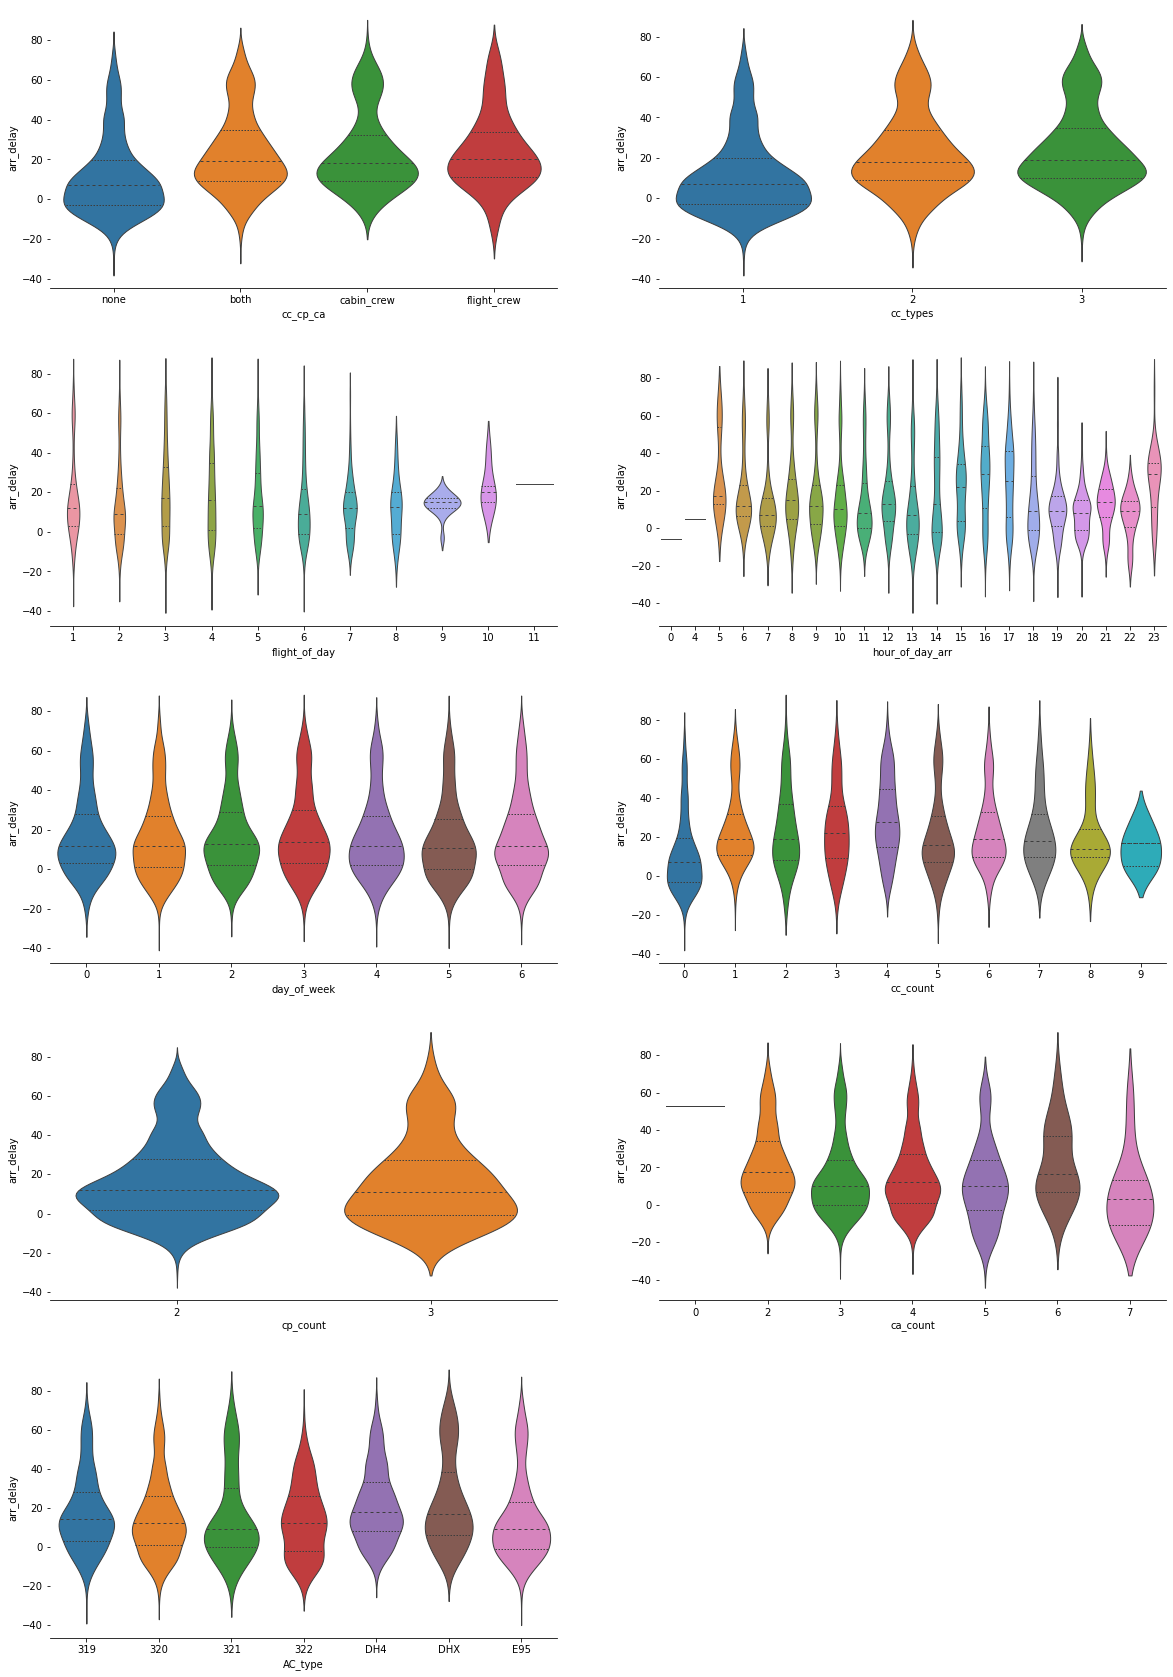

In [403]:
plt.figure(figsize=(20,30))
plt.subplot(5,2,1)
sns.violinplot(data=df_cleaned, x='cc_cp_ca', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

plt.subplot(5,2,2)
sns.violinplot(data=df_cleaned, x='cc_types', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

plt.subplot(5,2,3)
sns.violinplot(data=df_cleaned, x='flight_of_day', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

plt.subplot(5,2,4)
sns.violinplot(data=df_cleaned, x='hour_of_day_arr', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

plt.subplot(5,2,5)
sns.violinplot(data=df_cleaned, x='day_of_week', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

plt.subplot(5,2,6)
sns.violinplot(data=df_cleaned, x='cc_count', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

plt.subplot(5,2,7)
sns.violinplot(data=df_cleaned, x='cp_count', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

plt.subplot(5,2,8)
sns.violinplot(data=df_cleaned, x='ca_count', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

plt.subplot(5,2,9)
sns.violinplot(data=df_cleaned, x='AC_type', y='arr_delay',
    split=True, inner='quart', linewidth=1)
sns.despine(left=True)

In [404]:
# Final check on NaN values
total = df_cleaned.isnull().sum().sort_values(ascending=False)
percent = (df_cleaned.isnull().sum()/df_cleaned.isnull().count().sort_values(ascending=False))
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(28)

,Total,Percent
flt_ac_reg,0,0.0
cc_cp_ca,0,0.0
mod_sched_arr,0,0.0
cc_types,0,0.0
flight_of_day,0,0.0
hour_of_day_arr,0,0.0
hour_of_day_dep,0,0.0
day_of_week,0,0.0
cc_count,0,0.0
sched_trans_time,0,0.0


In [405]:
# Drop the rows with NaN values
print(df_cleaned.shape)
df_cleaned.dropna(inplace=True)
print(df_cleaned.shape)

(8242, 19)
(8242, 19)


In [406]:
# Final view on dataframe
df_cleaned.head()

,flt_ac_reg,dep_delay,gnd_mingt,arr_delay,AC_type,routing,sched_gt_before,cp_count,ca_count,sched_trans_time,cc_cp_ca,cc_count,day_of_week,hour_of_day_dep,hour_of_day_arr,flight_of_day,cc_types,mod_sched_arr,density
495776,ECLBRX,13.0,40.0,6.0,320,Vaughnberg_East Carmen,50.0,2,4,50,none,0,6,20,23,5,1,1380,0.01857
1001376,ECLDGX,3.0,40.0,-6.0,319,Kaylashire_East Carmen,60.0,2,3,60,none,0,2,20,23,6,1,1380,0.01857
646176,ECLBVX,14.0,40.0,0.0,320,Vaughnberg_East Carmen,50.0,2,4,50,none,0,6,20,23,5,1,1380,0.01857
245776,ECLBKX,13.0,40.0,-8.0,320,Vaughnberg_East Carmen,50.0,2,4,50,none,0,6,20,23,5,1,1380,0.01857
204976,ECLBIX,12.0,40.0,-9.0,320,Vaughnberg_East Carmen,50.0,2,4,50,none,0,6,20,23,5,1,1380,0.01857


In [407]:
df_cleaned.describe()

,dep_delay,gnd_mingt,arr_delay,sched_gt_before,cp_count,ca_count,sched_trans_time,cc_count,mod_sched_arr,density
count,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000,8242.000000
mean,21.301868,39.075467,16.709901,52.547319,2.029483,3.240233,41.687091,2.019413,867.449041,0.043256
std,19.200457,2.943571,20.701581,14.069204,0.169167,0.862205,26.575159,2.557170,253.764424,0.049176
min,-14.000000,30.000000,-31.000000,15.000000,2.000000,0.000000,0.000000,0.000000,25.000000,0.000000
25%,4.000000,40.000000,2.000000,45.000000,2.000000,3.000000,35.000000,0.000000,625.000000,0.000000
50%,16.000000,40.000000,12.000000,45.000000,2.000000,3.000000,45.000000,0.000000,865.000000,0.000000
75%,30.000000,40.000000,28.000000,60.000000,2.000000,4.000000,55.000000,5.000000,1073.750000,0.094979
max,72.000000,45.000000,78.000000,95.000000,3.000000,7.000000,315.000000,9.000000,1435.000000,0.131981


In [408]:
convert_dict = {'gnd_mingt': 'int',
                'cp_count': 'int',
                'ca_count': 'int',
                'cc_count': 'int',
                'day_of_week': 'int',
                'hour_of_day_dep': 'int',
                'hour_of_day_arr': 'int',
                'flight_of_day': 'int',
                'cc_types': 'int'
}
df_cleaned = df_cleaned.astype(convert_dict)

In [409]:
df_cleaned.to_csv('../data/processed/final.csv')
df_cleaned.to_pickle('../data/processed/final.pkl')

In [410]:
# One-hot encode all catgorical variables
df_one_hot = pd.get_dummies(df_cleaned, drop_first=True)
df_one_hot.dropna(axis=0, how='any', inplace=True)
df_one_hot.shape

(8242, 330)

In [411]:
df_one_hot.to_csv('../data/processed/final_one_hot.csv')
df_one_hot.to_pickle('../data/processed/final_one_hot.pkl')